In [29]:
import pandas as pd
import os
import numpy as np
import itertools

from scipy.spatial.distance import cdist
from sklearn.neighbors import NearestCentroid
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans

from sklearn.metrics import silhouette_samples, silhouette_score

from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['axes.grid'] = True
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['grid.linewidth'] = 0.8
plt.rcParams['grid.color'] = 'k'
# plt.rcParams['xtick.direction'] = 'in'
# plt.rcParams['ytick.direction'] = 'in'
# plt.rcParams['xtick.top'] = True
# plt.rcParams['ytick.right'] = True
# plt.rcParams['xtick.bottom'] = True
# plt.rcParams['ytick.left'] = True

In [2]:
df = pd.read_csv(os.getcwd() + '/data/data.csv').rename(columns={'Unnamed: 0':'sample_num'})

df.head()


,sample_num,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,sample_0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0
1,sample_1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0
2,sample_2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0
3,sample_3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0
4,sample_4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0


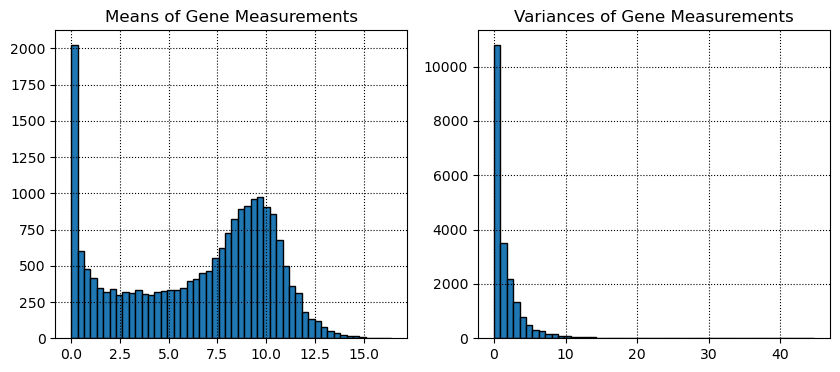

In [3]:
d = df.iloc[:, 1:].values
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(np.mean(d, axis=0), bins=50, edgecolor='k')
ax[0].set_title('Means of Gene Measurements')
ax[1].hist(np.var(d, axis=0), bins=50, edgecolor='k')
ax[1].set_title('Variances of Gene Measurements')

plt.show()


/tmp/ipykernel_2719/19163146.py:1: FutureWarning: The default value of numeric_only in DataFrame.var is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  gene_var = df.var()


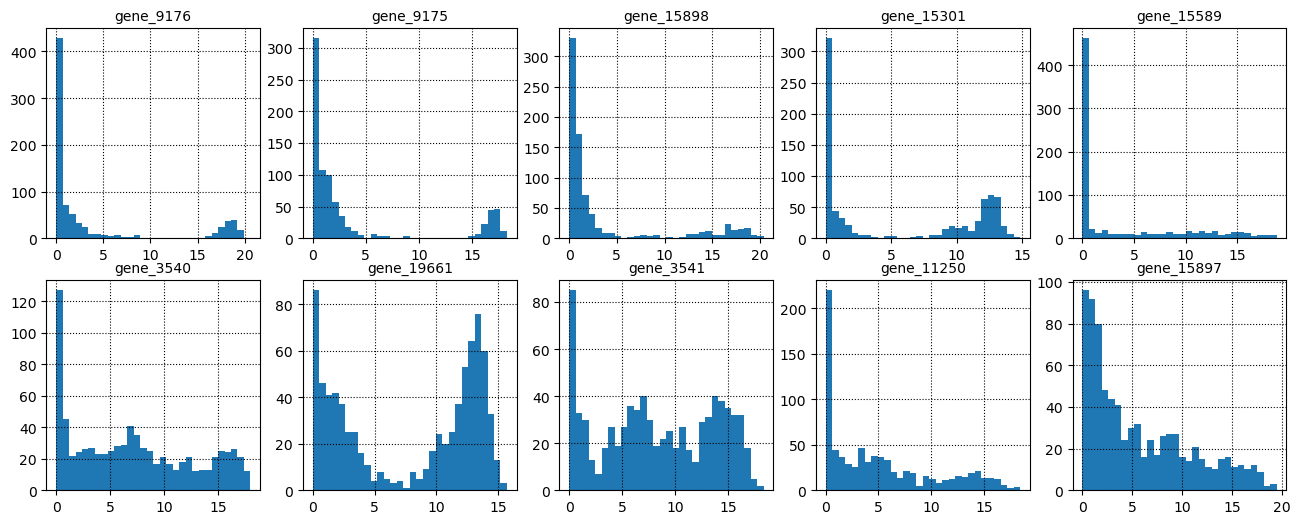

In [4]:

gene_var = df.var()
gene_var = gene_var.sort_values(ascending=False)
top_var_genes = np.array(gene_var.iloc[:10].index)#.reshape(2, 5)

fig, axes = plt.subplots(2, 5, figsize=(16, 6))
plots = zip(top_var_genes, axes.flatten())

for i, (gene, ax) in enumerate(plots):
    ax.hist(df[gene], bins=30)
    ax.set_title(f'{gene}', size=10)
plt.show()
    

In [5]:
def sctrmtrx(df, pairs, m, n, title, color_by=None):
    """
    Creates an m x n grid of scatter plots of selected columns. The number of column pairs must be equal to m x n.
    
    Parameters:
        df: Dataframe containing the columns to plot.
        pairs: Names of pairs of columns to plot.
        m: number of rows of scatter plots
        n: number of columns of scatter plots.
        color_by: pandas series, get from a column 

    Returns: 
        m x n Scatter plot figure.
    """
    

    fig, ax = plt.subplots(m, n, figsize=(16, 6))
    
    if color_by is not None:
        n_colors = len(color_by.unique())
        cm = plt.cm.get_cmap('turbo')
        colors = [cm(val/n_colors) for val in range(n_colors)]
        cmap = dict(zip(range(n_colors), colors))
        # cmap = {0:'tab:blue', 1:'tab:red', 2:'tab:orange', 3:'tab:green', 4:'tab:purple'}
        handles = [Line2D([], [], color=v, marker='o', linestyle='None', markersize=3, label=f'{k}', alpha=0.7, ) for k, v in cmap.items()]
        color = color_by.map(cmap)
        fig.legend(handles=handles,  loc='upper right', ncol=n_colors)
    else:
        color = 'tab:blue'

    d = dict(zip([(x, y) for x in range(0,m) for y in range(0,n)], pairs))
    for k, p in d.items():
        ax[k[0]][k[1]].scatter(df[p[0]], df[p[1]], c=color, s=25, alpha=0.7, edgecolor='k', linewidth=0.5)
        ax[k[0]][k[1]].set_xlabel(p[0])
        ax[k[0]][k[1]].set_ylabel(p[1])
 
    plt.suptitle(f'{title}', size=12)
    plt.tight_layout()
    plt.show()

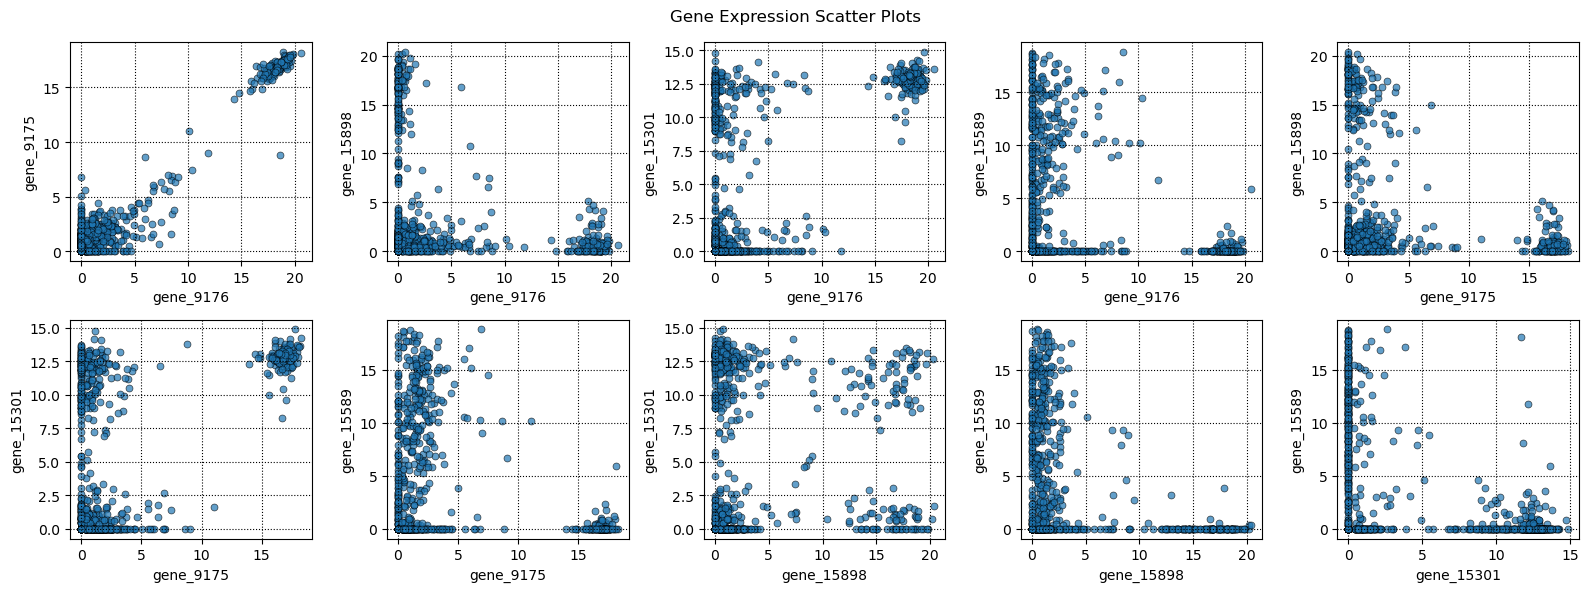

In [6]:
pairs = list(itertools.combinations(top_var_genes[:5], 2))
sctrmtrx(df=df, pairs=pairs, title='Gene Expression Scatter Plots', m=2, n=5)

In [7]:
def nboxplot(df, cols, title):
    """
    Boxplot of features.
    
    Parameters:
        df: Dataframe.
        cols: Columns within dataframe containing data to be plotted.

    Returns: 
        Boxplot figure.
    """
    plt.figure(figsize=(20, 3))

    boxplot = plt.boxplot(df[cols], 
                vert=True, 
                notch=True, 
                labels=cols,
                patch_artist=True,
                showfliers=False,
                  )

    cm = plt.cm.get_cmap('rainbow')
    colors = [cm(val/len(cols)) for val in range(len(cols))]
    for patch, color in zip(boxplot['boxes'], colors):
        patch.set_facecolor(color)

    plt.xticks(rotation=90)
    #plt.xlabel('Feature')
    plt.ylabel('Distribution')
    plt.title(title)
    plt.show()

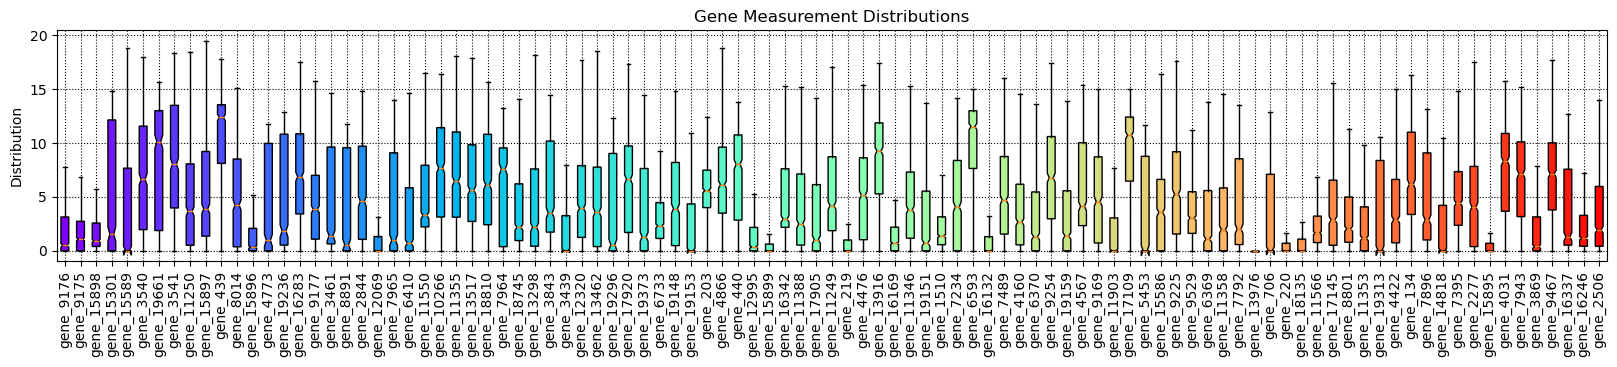

In [8]:
nboxplot(df=df, cols=list(gene_var.iloc[:99].index), title='Gene Measurement Distributions')

In [9]:
# drop genes with 0 variance
df = df.drop(columns=list(gene_var[gene_var == 0].index))

df.head()

,sample_num,gene_0,gene_1,gene_2,gene_3,gene_4,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,sample_0,0.0,2.017209,3.265527,5.478487,10.431999,7.175175,0.591871,0.0,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0
1,sample_1,0.0,0.592732,1.588421,7.586157,9.623011,6.816049,0.000000,0.0,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0
2,sample_2,0.0,3.511759,4.327199,6.881787,9.870730,6.972130,0.452595,0.0,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0
3,sample_3,0.0,3.663618,4.507649,6.659068,10.196184,7.843375,0.434882,0.0,0.0,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0
4,sample_4,0.0,2.655741,2.821547,6.539454,9.738265,6.566967,0.360982,0.0,0.0,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0


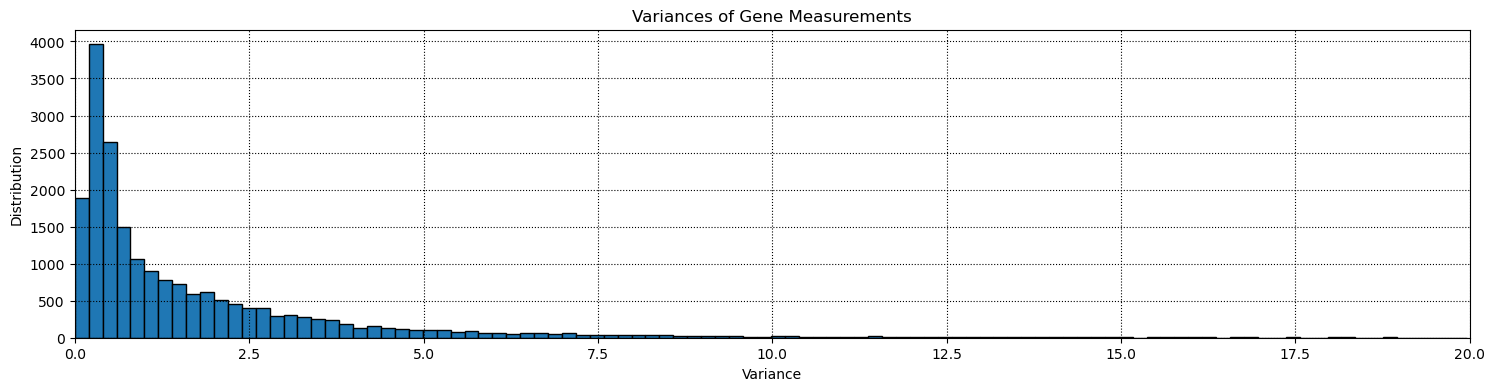

In [10]:
d = df.iloc[:, 1:].values
fig, ax = plt.subplots(figsize=(18, 4))
ax.hist(
        np.var(d, axis=0)[np.var(d, axis=0) <= 20], 
        bins=100, 
        edgecolor='k'
       )
ax.set_xlim(0, 20)
ax.set_ylabel('Distribution')
ax.set_xlabel('Variance')
ax.set_title('Variances of Gene Measurements')

plt.show()

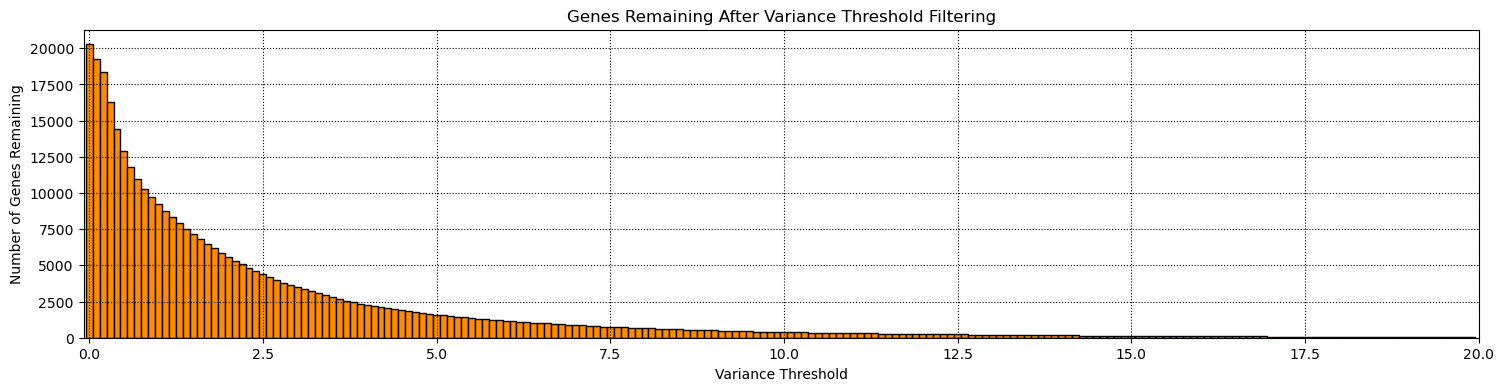

In [11]:
d = df.iloc[:, 1:].values

vts = {v:VarianceThreshold(v).fit(d) for v in np.arange(0, 20.0, 0.1)}
thresh_counts = pd.DataFrame.from_dict({round(k, 1):v.get_support().sum() for k, v in vts.items()}, orient='index')

fig, ax = plt.subplots(figsize=(18, 4))
ax.bar(x=thresh_counts[0].index, height=thresh_counts[0], edgecolor='k', width=0.1, color='darkorange')
ax.set_xlim(-0.08, 20)
ax.set_ylabel('Number of Genes Remaining')
ax.set_xlabel('Variance Threshold')
ax.set_title('Genes Remaining After Variance Threshold Filtering')
plt.show()


In [135]:
# filter genes with less than variance threshold
var_filter = VarianceThreshold(5.0)
var_filter.fit(df.iloc[:, 1:].values)
df_var_filt = df.iloc[:, [True] + list(var_filter.get_support())].copy()


In [136]:

# scale
X = df_var_filt.iloc[:, 1:].values
ss = StandardScaler()
ss = ss.fit(X)
X_scaled = ss.transform(X)

pca = PCA()
X_scaled_pca = pca.fit_transform(X_scaled)
X_scaled_pca = pd.DataFrame(X_scaled_pca)
X_scaled_pca.columns = [f'PC_{n+1}' for n in X_scaled_pca.columns]

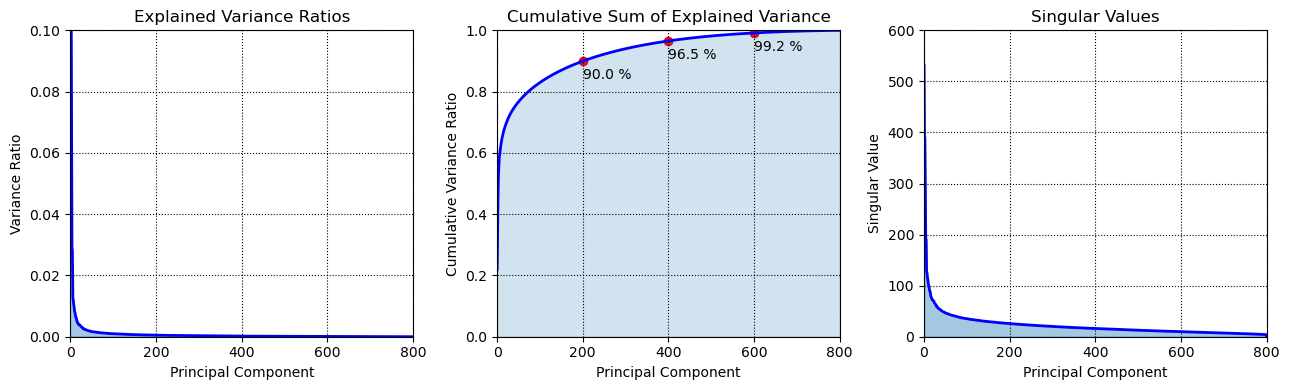

In [137]:
# plot variables
n = pca.n_components_
a = list(range(0, n))
r = range(pca.n_components_)

# PC variance ratios
fig, ax = plt.subplots(1, 3, figsize=(13, 4))
ax[0].plot(r, pca.explained_variance_ratio_, linewidth=2, color='blue')
#ax[0].set_yscale('log')
ax[0].set_ylabel('Variance Ratio')
ax[0].set_xlabel('Principal Component')
ax[0].set_xlim(0, 801)
ax[0].set_ylim(0, 0.1)
ax[0].fill_between(a, pca.explained_variance_ratio_, color='tab:blue', alpha=0.4)
ax[0].set_title('Explained Variance Ratios', size=12)


# cumulative explained variance ratio
d = pd.DataFrame([200, 400, 600], 
              [
                  np.cumsum(pca.explained_variance_ratio_)[200],
                  np.cumsum(pca.explained_variance_ratio_)[400],
                  np.cumsum(pca.explained_variance_ratio_)[600],
              ]).reset_index().rename(columns={'index':'cum_var', 0:'pcs'})

ax[1].plot(np.cumsum(pca.explained_variance_ratio_), linewidth=2, color='blue')
ax[1].scatter(d['pcs'], d['cum_var'], color='red')

for cum_var, x, y in zip(d['cum_var'], d['pcs'], d['cum_var']):
    ax[1].annotate(f'{round(cum_var * 100, 1) } %', xy=(x, y-0.06), )

ax[1].set_ylabel('Cumulative Variance Ratio')
ax[1].set_xlabel('Principal Component')
ax[1].set_xlim(0, 801)
ax[1].set_ylim(0, 1)
ax[1].fill_between(a, np.cumsum(pca.explained_variance_ratio_), color='tab:blue', alpha=0.2)
ax[1].set_title('Cumulative Sum of Explained Variance', size=12)


# singular values per PC
ax[2].plot(r, pca.singular_values_, linewidth=2, color='blue')
#ax[0].set_yscale('log')
ax[2].set_ylabel('Singular Value')
ax[2].set_xlabel('Principal Component')
ax[2].set_xlim(0, 801)
ax[2].set_ylim(0, 600)
ax[2].fill_between(a, pca.singular_values_, color='tab:blue', alpha=0.4)
ax[2].set_title('Singular Values', size=12)
plt.tight_layout()
plt.show()


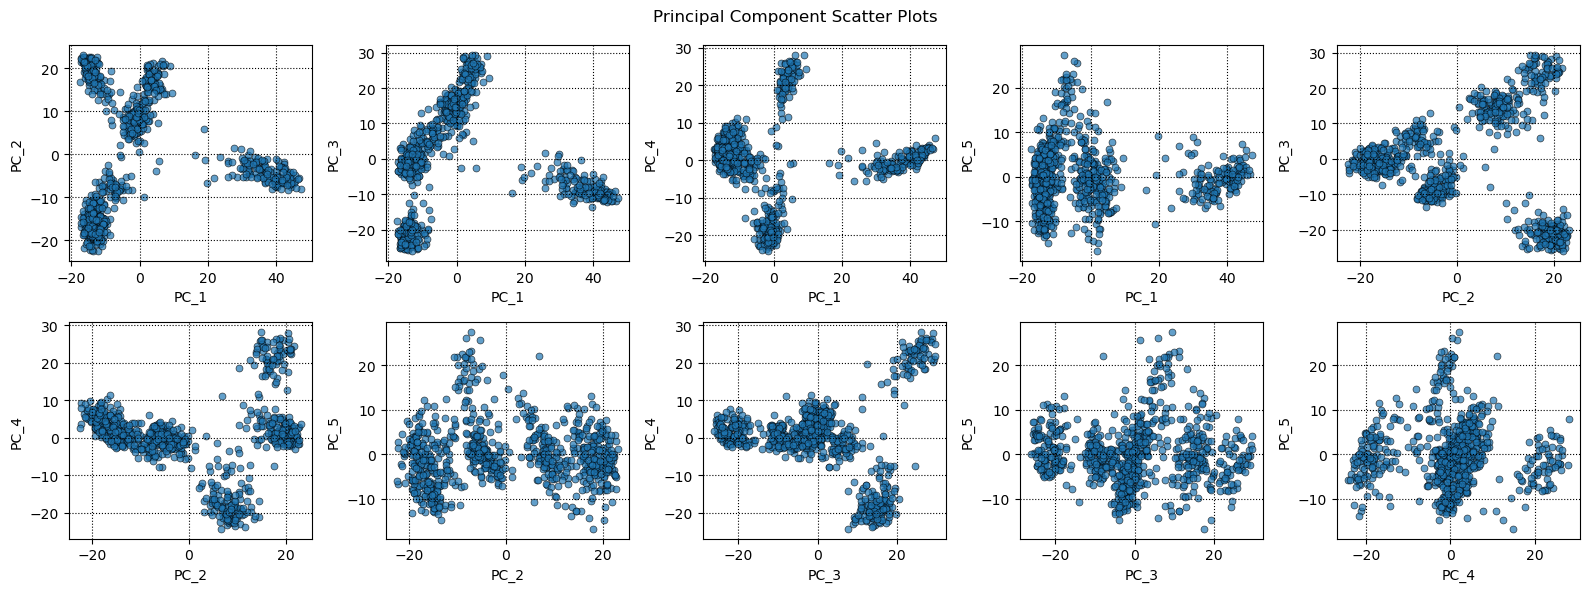

In [138]:
pairs = list(itertools.combinations(list(X_scaled_pca.columns[:5]), 2))
sctrmtrx(df=X_scaled_pca, pairs=pairs, m=2, n=5, title='Principal Component Scatter Plots')

In [139]:
X_train = X_scaled_pca.iloc[:, :10]
X_train.head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10
0,-15.591599,19.344130,-18.964057,0.058341,-3.502234,3.787289,3.668191,8.406563,0.231427,-2.387740
1,-1.177606,2.537190,17.297847,-13.020199,12.551381,-5.168949,-2.166868,-1.048071,-9.142975,-4.403061
2,-8.225365,6.887326,-7.863028,10.963681,21.940010,-14.739619,2.166814,-0.084387,-1.767342,-3.818669
3,-17.564107,16.808376,-17.576018,3.048143,6.211114,-4.984613,2.876137,4.554060,-3.267486,3.925349
4,-17.069995,-17.013076,-0.812145,2.698193,-1.640227,4.030246,1.892603,5.863971,-4.437971,8.234437


### DBSCAN

In [ ]:
epss = np.arange(0.5, 30, 0.1)
min_samples = list(range(5, 100))

sil_scores = []
for e in epss:
    for m in min_samples:
        try:
            db = DBSCAN(eps=e, min_samples=m)
            sil_scores.append([e, m, silhouette_score(X_train.values, db.fit_predict(X_train.values))])
        except:
            sil_scores.append([e, m, 0])

In [ ]:
db = DBSCAN(eps=db_best_score[0], min_samples=int(db_best_score[1]))
centroid_db = [NearestCentroid().fit(X_train.values, db.fit_predict(X_train.values)).centroids_]
# compute euclidean distance between each point and each centroid
dists_by_ks = [cdist(X_train.values, mid, 'euclidean') for mid in centroid_db]
# get minimum distance per point, i.e., distance from assigned centroid
min_distances = [np.min(d, axis=1) for d in dists_by_ks] 
# total within sum of squares
tss_db = [sum(d**2) for d in min_distances]

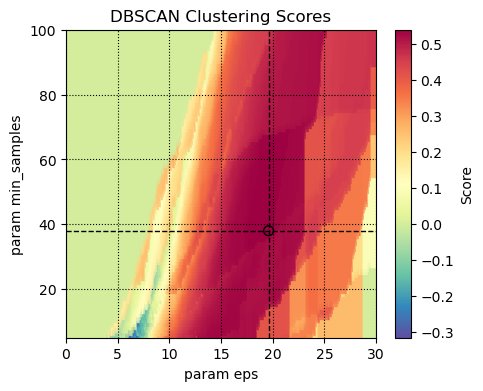

In [94]:
db_cv_res = pd.DataFrame(sil_scores)#.pivot_table(index=0, columns=1, values=2)
db_best_sil_score = db_cv_res.iloc[db_cv_res[2].idxmax()]
fig, ax = plt.subplots(figsize=(5, 4))

sc = ax.scatter(
            x=db_cv_res[0],
            y=db_cv_res[1], 
            c=db_cv_res[2],
            marker='s',
            cmap='Spectral_r',
           )
fig.colorbar(sc, ax=ax, label='Score')
sc = ax.scatter(
            x=db_best_sil_score[0],
            y=db_best_sil_score[1], 
            marker='o',
            facecolors='none',
            edgecolors='k',
            s=50,
           )
ax.axhline(db_best_sil_score[1], color='k', linestyle='--', linewidth=1, )
ax.axvline(db_best_sil_score[0], color='k', linestyle='--', linewidth=1, )

ax.set_xlim(0, 30)
ax.set_ylim(5, 100)

ax.set_xlabel("param eps", )
ax.set_ylabel("param min_samples", )
# plt.legend()
plt.title('DBSCAN Clustering Scores')
plt.show()

In [ ]:
n_clusters = range(2, 11)

# KMeans Clustering
kms = {n:KMeans(n_clusters=n, random_state=0, n_init=30) for n in n_clusters}
centroids_km = [kms[n].fit(X_train.values).cluster_centers_ for n in n_clusters]
# compute euclidean distance between each point and each centroid
dists_by_ks = [cdist(X_train.values, mid, 'euclidean') for mid in centroids_km]
# get minimum distance per point, i.e., distance from assigned centroid
min_distances = [np.min(d, axis=1) for d in dists_by_ks] 
# total within sum of squares
tss_km = [sum(d**2) for d in min_distances]

# more succint way to get tss and elbo plot for KMeans
# dists = {k.n_clusters:k.inertia_ for k in KMs}
# pd.DataFrame.from_dict(dists, orient='index').plot()

In [17]:
# Hierarchical (Agglomerative) Clustering
hcs = {n:AgglomerativeClustering(n_clusters=n, linkage='ward') for n in n_clusters}
centroids_hc = [NearestCentroid().fit(X_train.values, hcs[n].fit_predict(X_train.values)).centroids_ for n in n_clusters]
# compute euclidean distance between each point and each centroid
dists_by_ks = [cdist(X_train.values, mid, 'euclidean') for mid in centroids_hc]
# get minimum distance per point, i.e., distance from assigned centroid
min_distances = [np.min(d, axis=1) for d in dists_by_ks] 
# total within sum of squares
tss_hc = [sum(d**2) for d in min_distances]


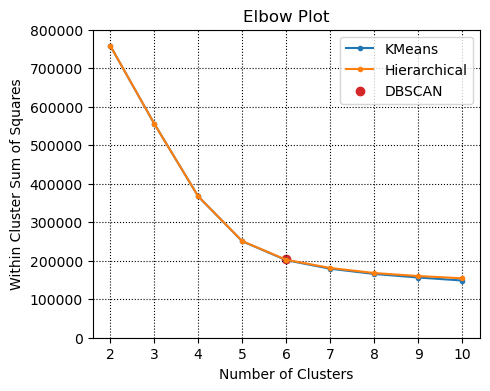

In [113]:
fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(n_clusters, tss_km, '.-', color='tab:blue', label='KMeans')
ax.plot(n_clusters, tss_hc, '.-', color='tab:orange', label='Hierarchical')
ax.scatter(np.unique(db.labels_).shape[0], tss_db, color='tab:red', label='DBSCAN', )
# ax.axvline(6, color='k', linestyle='--')
ax.set_ylim(0, 800000)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Within Cluster Sum of Squares')
ax.set_title('Elbow Plot')
ax.legend()
plt.show()

In [127]:
tss_comp = {'DBSCAN':tss_db[0],
            'KMeans':tss_km[n_clusters.index(6)],
            'Hierarchical':tss_hc[n_clusters.index(6)],
                }
tss_comp = pd.DataFrame.from_dict(tss_comp, orient='index').round(2)
tss_comp.columns = ['TSS']
tss_comp

,TSS
DBSCAN,204308.69
KMeans,201371.05
Hierarchical,202399.54


There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster and also how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the average distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as
$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on every datapoint in every cluster. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

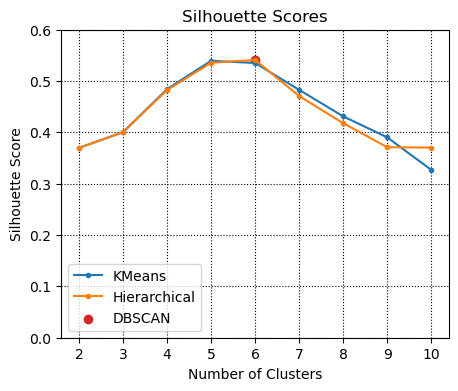

In [92]:
sil_km = [silhouette_score(X_train.values, kms[n].fit_predict(X_train.values)) for n in n_clusters]
sil_hc = [silhouette_score(X_train.values, hcs[n].fit_predict(X_train.values)) for n in n_clusters]

fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(list(n_clusters), sil_km, '.-', color='tab:blue', label='KMeans')
ax.plot(list(n_clusters), sil_hc, '.-', color='tab:orange', label='Hierarchical')
ax.scatter(np.unique(db.labels_).shape[0], db_best_score[2], color='tab:red', label='DBSCAN')

#ax.plot(6, np.mean([sil_km[4], sil_hc[4]]), marker='o', markersize=10, markeredgewidth=1, markeredgecolor='r', markerfacecolor='None')

ax.set_ylim(0, 0.6)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhouette Score')
ax.set_title('Silhouette Scores')
ax.legend()
plt.show()

In [134]:
sil_comp = {'DBSCAN':db_best_sil_score[2],
            'KMeans':sil_km[n_clusters.index(6)],
            'Hierarchical':sil_hc[n_clusters.index(6)],
                }
sil_comp = pd.DataFrame.from_dict(sil_comp, orient='index').round(2)
sil_comp.columns = ['Silhouette Score']
sil_comp

,Silhouette Score
DBSCAN,0.54
KMeans,0.54
Hierarchical,0.54


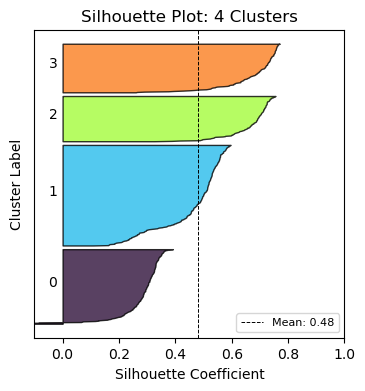

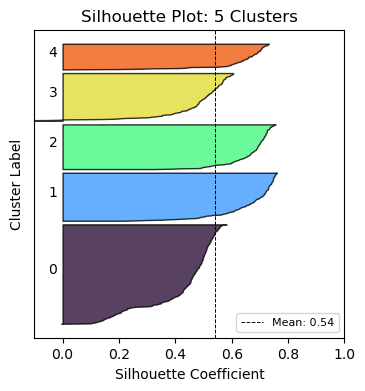

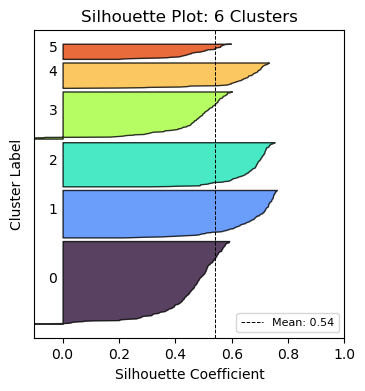

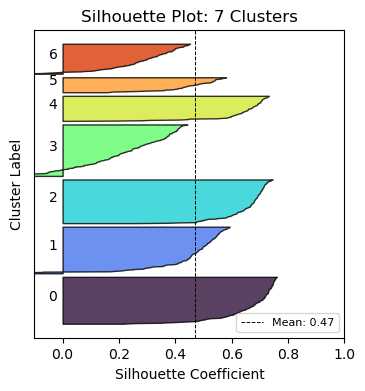

In [25]:

for n in range(4, 8):
    labels = hcs[n].fit_predict(X_train.values)
    silhouette_coeffs = silhouette_samples(X_train.values, labels)
    mean_val = round(np.mean(silhouette_coeffs), 2)
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.grid(False)
    y_lower = 10
    for clst_num in range(n):

        clstr_silt_coefs = silhouette_coeffs[labels == clst_num] # locate silhouette coefficients within cluster 
        clstr_silt_coefs.sort() # sort within cluster
        cluster_size = clstr_silt_coefs.shape[0]
        y_upper = y_lower + cluster_size

        cm = plt.cm.get_cmap('turbo')
        color = cm(clst_num/n) 

        # print(f'n:{n}    clst:{clst_num} \n')
        # print(f'y_lower:{y_lower}    y_upper:{y_upper}')
#         print(np.arange(y_lower, y_upper), '\n')

        ax.fill_betweenx(
            y=np.arange(y_lower, y_upper),
            x1=0,
            x2=clstr_silt_coefs,
            facecolor=color,
            edgecolor='k',
            alpha=0.8,
                        )

        ax.text(-0.05, y_lower + 0.5 * cluster_size, str(clst_num)) # label with cluster nums
        # compute new y_lower for next plot
        y_lower = y_upper + 10  # +10 for separation
        
    ax.axvline(mean_val, linestyle='--', linewidth=0.7, color='k', label=f'Mean: {mean_val:.2f}')
    ax.legend(loc=4, fontsize=8)
    ax.set_xlim(-0.1, 1)
    ax.set_xlabel("Silhouette Coefficient")
    ax.set_ylabel("Cluster Label")
    ax.set_yticks([])
    ax.set_title(f"Silhouette Plot: {n} Clusters")
    plt.show()

In [97]:
n = 6

df_res = X_scaled_pca.copy()

km = KMeans(n_clusters=n, random_state=0, n_init=30)
df_res['km'] = km.fit_predict(X_train.values)

hc = AgglomerativeClustering(n_clusters=n, linkage='ward')
df_res['hc'] = hc.fit_predict(X_train.values)

db = DBSCAN(eps=19.6, min_samples=38)
df_res['db'] = db.fit_predict(X_train.values)+1

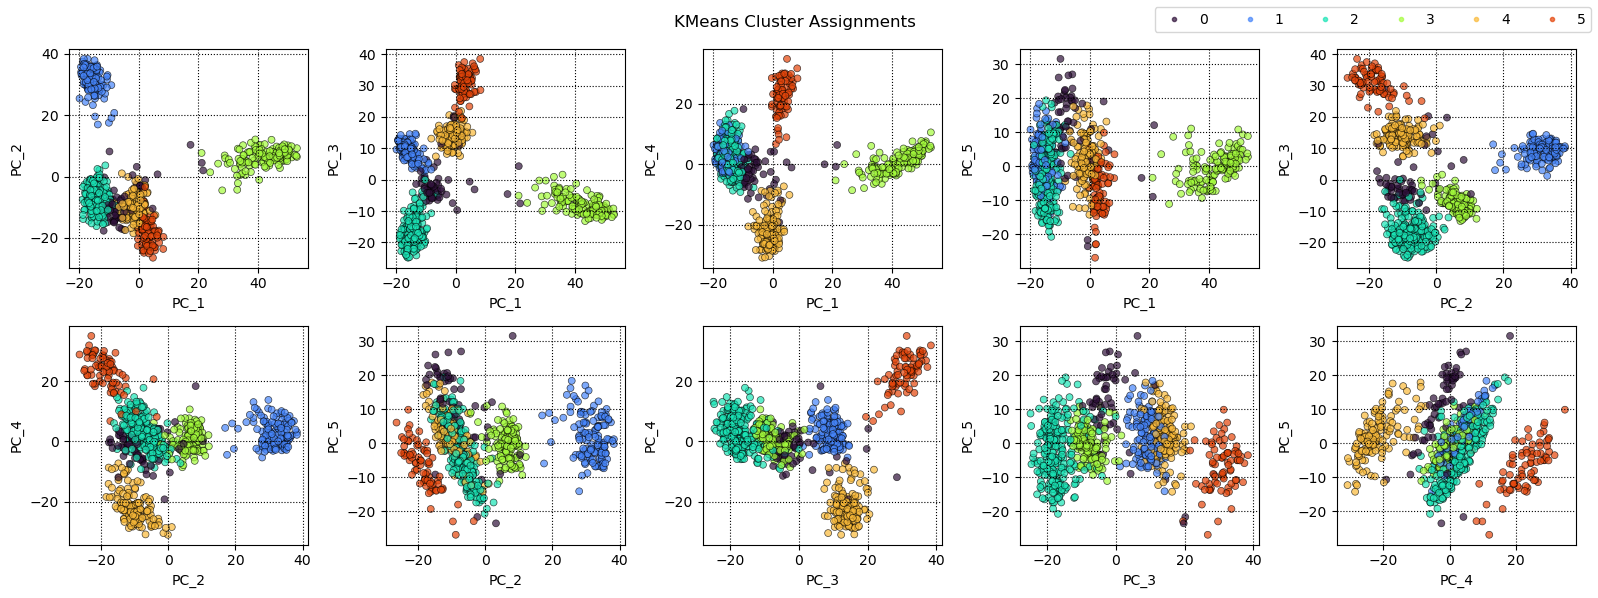

In [98]:
pairs = list(itertools.combinations(list(X_scaled_pca.columns[:5]), 2))
sctrmtrx(df=df_res, pairs=pairs, m=2, n=5, title='KMeans Cluster Assignments', color_by=df_res['db'])

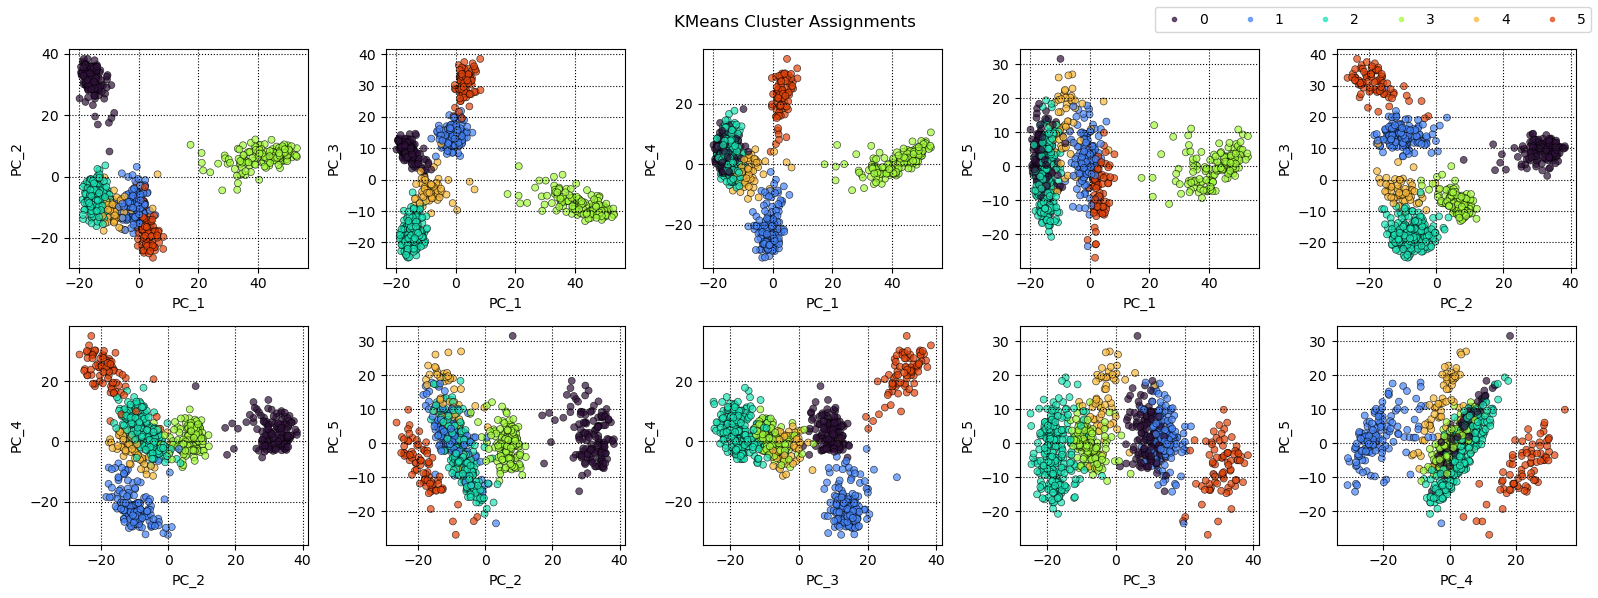

In [23]:
pairs = list(itertools.combinations(list(X_scaled_pca.columns[:5]), 2))
sctrmtrx(df=df_res, pairs=pairs, m=2, n=5, title='KMeans Cluster Assignments', color_by=df_res['km'])

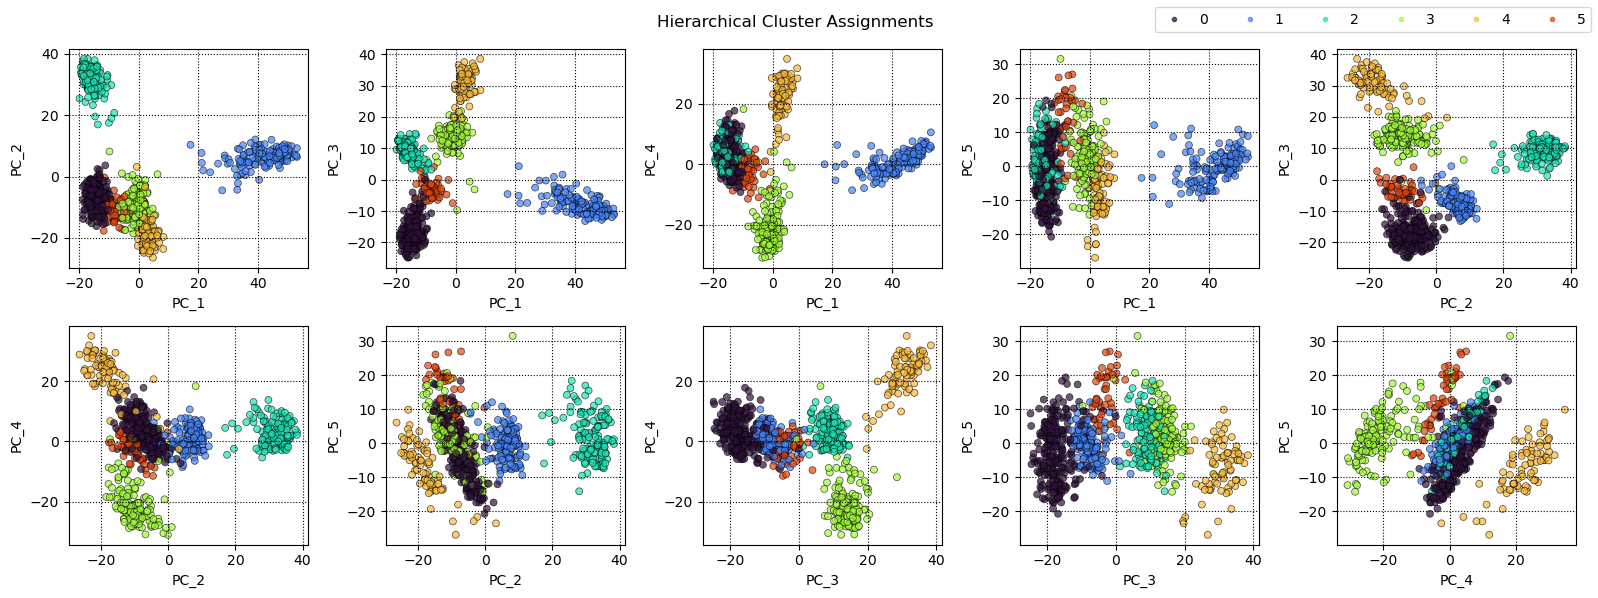

In [24]:
pairs = list(itertools.combinations(list(X_scaled_pca.columns[:5]), 2))
sctrmtrx(df=df_res, pairs=pairs, m=2, n=5, title='Hierarchical Cluster Assignments', color_by=df_res['hc'])